# Run Test-Time Simulation with Single Reward Model

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import yaml 
import json

In [2]:
'---- Load the computed reward scores of each prompt, each image and each timestep ---'
value_folder = 'values'
diffusion_model = 'flux' # flux or sdxl
reward_model = 'imr' # imr or pic or hps
num_prompt = 200 # number of prompts to use
num_image = 200 # number of images per prompt
num_steps = 20 # number of diffusion inference timesteps

reward_base_all = []  # shape (num_prompt, num_image, num_steps)
reward_naft_all = [] # shape (num_prompt, num_image, num_steps)

location_base = f'{value_folder}/{diffusion_model}_{reward_model}_val_base'
for s in np.arange(num_steps):
    file_name = f'p{num_prompt}_i{num_image}_s{s:02d}.yaml'
    r_dict = yaml.safe_load(open(f'{location_base}/{file_name}')) 
    reward_one_step = np.stack([r_dict[k] for k in sorted(r_dict.keys())], axis=0) # shape (num_prompt, num_image)
    reward_base_all.append(reward_one_step)
reward_base_all = np.stack(reward_base_all, axis=-1) # shape (num_prompt, num_image, num_steps)
print(f'Loaded base reward scores with shape: {reward_base_all.shape}')

location_naft = f'{value_folder}/{diffusion_model}_{reward_model}_val_naft'
for s in np.arange(num_steps):
    file_name = f'p{num_prompt}_i{num_image}_s{s:02d}.yaml'
    if not os.path.exists(f'{location_naft}/{file_name}'):
        # some steps are not used for naft and we use base values instead, e.g. steps too high or too low
        r_dict = yaml.safe_load(open(f'{location_base}/{file_name}')) 
    else:
        r_dict = yaml.safe_load(open(f'{location_naft}/{file_name}')) 
    reward_one_step = np.stack([r_dict[k] for k in sorted(r_dict.keys())], axis=0) # shape (num_prompt, num_image)
    reward_naft_all.append(reward_one_step)
reward_naft_all = np.stack(reward_naft_all, axis=-1) # shape (num_prompt, num_image, num_steps)

print(f'Loaded naft reward scores with shape: {reward_naft_all.shape}')

Loaded base reward scores with shape: (200, 200, 20)
Loaded naft reward scores with shape: (200, 200, 20)


In [ ]:
'Compare TTSnap, TTSp and Best-of-N'
from ttsnap_sim import *

denoise_budget = 9.9 # TFlops
verifier_budget = 1.2 # TFlops

budget = 2000 
iters = 40

S = Simulation(x=denoise_budget, y=verifier_budget, max_step=num_steps)

# Best-of-N
n = int(budget / S.bon_cost())
print('Number of images seen in Best-of-N:', n)
r_bon, _ = S.bon_run(reward_base_all[:,:,-1], image_num_use=n, iters=iters)

# TTsnap
alphas = [0.4, 0.4, 0.5] # hyperparameters
steps_use = [2, 6, 11] # hyperparameters
n = int(budget / S.ttsp_cost(alpha_s=alphas, steps_use=steps_use))
print('Number of images seen in TTsnap:', n)
r_ttsp, _ = S.ttsp_run(reward_naft_all, image_num_use=n, alpha_s=alphas, steps_use=steps_use, iters=iters)

print('Averaged reward Best-of-N of all the prompts:', r_bon)
print('Averaged reward TTsnap of all the prompts:', r_ttsp)

Number of images used Best-of-N: 10
Number of images used TTsnap: 38
Averaged reward Best-of-N of all the prompts: 1.644121504655399
Averaged reward TTsnap of all the prompts: 1.7378503455044119


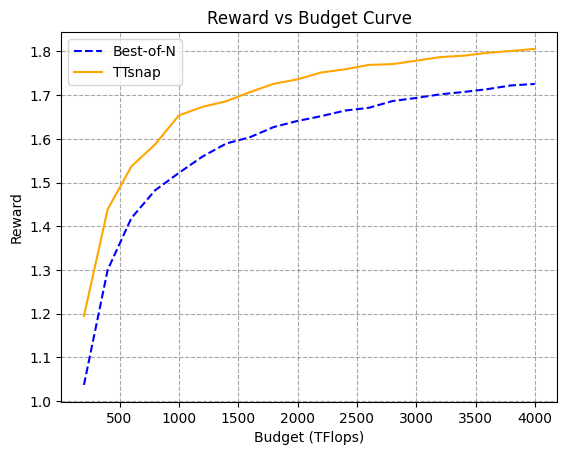

relative increase: 17.84%


In [25]:
'Plot and evaluation under different budgets settings'
from ttsnap_sim import *
from scipy import integrate
from matplotlib import pyplot as plt

denoise_budget = 9.9 # TFlops
verifier_budget = 1.2 # TFlops

budget_start = 200 
budget_end = 4000 
iters = 40

S = Simulation(x=denoise_budget, y=verifier_budget, max_step=num_steps)

results_bon = []
results_ttsp = []
for budget in range(budget_start, budget_end+1, 200):
    # Best-of-N
    n = int(budget / S.bon_cost())
    r_bon, _ = S.bon_run(reward_base_all[:,:,-1], image_num_use=n, iters=iters)
    results_bon.append(r_bon)

    # TTsnap
    alphas = [0.4, 0.4, 0.5] # hyperparameters
    steps_use = [2, 6, 11] # hyperparameters
    n = int(budget / S.ttsp_cost(alpha_s=alphas, steps_use=steps_use))
    r_ttsp, _ = S.ttsp_run(reward_naft_all, image_num_use=n, alpha_s=alphas, steps_use=steps_use, iters=iters)
    results_ttsp.append(r_ttsp)


# Plot the reward vs budget curves
def plot_curve(budgets, rewards_out1, rewards_out2, label1, label2):
    plt.plot(budgets, rewards_out1, label=label1, color='blue', linestyle='--')
    plt.plot(budgets, rewards_out2, label=label2, color='orange')
    plt.xlabel('Budget (TFlops)')
    plt.ylabel('Reward')
    plt.title('Reward vs Budget Curve')
    plt.legend()
    plt.grid(linestyle='--', color='gray', alpha=0.7)
    plt.show()


def evaluate(budgets, rs, rs_base):
    # rs: PTTS
    # rs_base: TTS
    assert len(budgets) == len(rs) == len(rs_base), "Lengths must match."
    assert (np.arange(len(budgets))==np.argsort(budgets)).all(), "Budgets must be sorted in ascending order."
    y0 = np.array(rs_base)[0]
    y_rs = np.array(rs) - y0
    y_rs_base = np.array(rs_base) - y0
    area1 = integrate.simpson(y=y_rs, x=budgets)
    area2 = integrate.simpson(y=y_rs_base, x=budgets)
    increase = (area1 - area2) / area2 if area2 != 0 else float('inf')
    increase = np.round(100*increase, 2)
    print(f'relative increase: {increase.item()}%')

budgets = list(range(budget_start, budget_end+1, 200))
plot_curve(budgets, results_bon, results_ttsp, label1='Best-of-N', label2='TTsnap')
omega = evaluate(budgets, results_ttsp, results_bon)
